In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

# Importing Time Series stats stuff
! pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse, rmse, meanabs

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Importing Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

# Text analysis
! pip install vaderSentiment

# Reading the data
# df_raw = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/AEP_data.csv', index_col="date", parse_dates=True)
df_raw = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/GOOGL_data_with_news_3.csv', index_col="date", parse_dates=True)
df_raw = df_raw.resample('B').pad()
df_raw.index.freq = 'B'
df_raw.drop(['Name'], axis=1, inplace=True)

# df_raw = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/google_facebook_microsoft_news.csv')
# df_raw.drop(['Name', 'Unnamed: 0', 'date'], axis=1, inplace=True)



df_raw['news'] = df_raw['main_news'].replace(np.nan, '', regex=True)
df_raw = df_raw.drop(['main_news', 'tagged_news'], axis=1)

df_with_targets = df_raw.copy()
predict_num_days_ahead = 2
df_with_targets['target_reg'] = df_with_targets['open'].shift(-predict_num_days_ahead)
df_with_targets = df_with_targets.iloc[:-1]
df_with_targets['target_class'] = df_with_targets['target_reg'] > df_with_targets['close']
df = df_with_targets.copy()
df = df.dropna()


# Feature Engineering
# ===== Add moving averages (close) =====
df = df_with_targets.copy()
window_size = [50, 20, 5]
max_window_size = max(window_size)
for k in range(len(window_size)):
  moving_avg = 0
  for i in range(max_window_size + 1 - window_size[k], max_window_size + 1):
    moving_avg = moving_avg + df_raw.iloc[i]['close']
  moving_avg = moving_avg / window_size[k]

  df['moving_avg_' + str(window_size[k])] = np.nan
  col_index = df.columns.get_loc("moving_avg_" + str(window_size[k]))
  for j in range(max_window_size, len(df) - 1):
    df.iat[j, col_index] = moving_avg
    moving_avg = moving_avg + (df_raw.iloc[j+1]['close'] - df_raw.iloc[j+1-window_size[k]]['close'])/window_size[k]
df = df.dropna()


y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

# Importing Time Series stats stuff
! pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse, rmse, meanabs

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Importing Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

# Text analysis
! pip install vaderSentiment

     |████████████████████████████████| 1.1MB 9.6MB/s 


Using TensorFlow backend.


     |████████████████████████████████| 133kB 9.7MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Follow the instructions in the output after executing this code (go to the URL, authorize, and copy the authorization code)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Load Data (choose 1 - Time Series, Normal)

(Option 1) As a Time Series Dataframe (Only works for one S&P company at a time):

In [4]:
# You need to move the CS3244 Folder from "Shared With Me" into "My Drive"
df_raw = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/GOOGL_data_with_news_3.csv', index_col="date", parse_dates=True)
# df_raw = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/AEP_data.csv', index_col="date", parse_dates=True)
df_raw = df_raw.resample('B').pad()
df_raw.index.freq = 'B'
df_raw.drop('Name', axis=1, inplace=True)
df_raw['news'] = df_raw['main_news'].replace(np.nan, '', regex=True)
df_raw = df_raw.drop(['main_news', 'tagged_news'], axis=1)
df_raw.head(5)


,open,high,low,close,volume,news
date,,,,,,
2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199,Google Changes Its Ad Program to Try to Solve ...
2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781,
2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176,
2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946,Lost in Translation? Try a Google App: Google’...
2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971,


(Option 2) As a normal Dataframe for all companies dataset:

In [0]:
df_raw = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/all_stocks_5yr.csv')
df_raw.drop('date', axis=1, inplace=True)
df_raw.dropna(inplace=True)
df_raw.head()

,open,high,low,close,volume,Name
0,15.07,15.12,14.63,14.75,8407500,AAL
1,14.89,15.01,14.26,14.46,8882000,AAL
2,14.45,14.51,14.10,14.27,8126000,AAL
3,14.30,14.94,14.25,14.66,10259500,AAL
4,14.94,14.96,13.16,13.99,31879900,AAL


In [0]:
def get_summary(df):
    print("Shape: ", df.shape)
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Percentage Missing'] = df.isnull().sum().values / df.shape[0]
    summary['Uniques'] = df.nunique().values
    return summary

get_summary(df)

Shape:  (1280, 10)


,Name,dtypes,Missing,Percentage Missing,Uniques
0,open,float64,0,0.0,1018
1,high,float64,0,0.0,405
2,low,float64,0,0.0,432
3,close,float64,0,0.0,420
4,volume,int64,0,0.0,1232
5,moving_avg,float64,0,0.0,1273
6,amount_traded,float64,0,0.0,1232
7,volume_prev_1,float64,0,0.0,1232
8,target_reg,float64,0,0.0,1018
9,target_class,bool,0,0.0,1


(Option 3) Using already preprocessed data with only news (note that you do not need to go to the data preprocessing step after this step)

In [0]:
df_raw = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/combined_news.csv')
df_raw = df_raw.dropna() # to be commented out if necessary
df_raw['news'] = df_raw['main_news'].replace(np.nan, '', regex=True)
df_raw = df_raw.drop(["date", 'Unnamed: 0', 'tagged_news', 'main_news'], axis=1)
# df_raw = df_raw[df_raw['Name'] == "MSFT"]
df = df_raw.drop(['Name'], axis=1)
df.head()

,open,high,low,close,volume,target_reg,target_class,news
8,399.3990,403.1277,396.0056,398.1628,7008464,401.5512,True,Google Searches for Style: As Google and other...
20,416.2608,420.2699,416.1658,417.8274,3186118,414.3639,False,NELL Is a Computer That Reads the Web – With a...
21,415.7704,416.3609,412.2468,414.2188,4012146,413.9085,False,Google Concedes That Drive-By Prying Violated ...
24,409.6592,410.5602,407.0767,407.5582,6191734,406.0256,False,Pushing the Boundaries of the Workplace: Googl...
25,402.9025,406.7864,401.1357,404.2989,3672831,408.8234,True,Google Executive to Visit Myanmar: Eric Schmid...


In [0]:
df_raw = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/google_facebook_microsoft_news.csv')
df_raw.tail()

,Unnamed: 0,date,open,high,low,close,volume,Name,main_news,tagged_news,target_reg,target_class
1548,1211,2017-11-29,84.71,84.9172,83.175,83.34,27381109,MSFT,"Microsoft to Expand Campus, as Amazon Looks El...",NaN,83.600,True
1549,1220,2017-12-12,85.31,86.0500,85.080,85.58,23924105,MSFT,"Net Neutrality Protests Move Online, Yet Big T...",NaN,85.430,False
1550,1225,2017-12-19,86.35,86.3500,85.270,85.83,23524787,MSFT,Microsoft Moves to End Secrecy in Sexual Haras...,NaN,86.050,True
1551,1247,2018-01-23,91.90,92.3000,91.540,91.90,23412841,MSFT,"‘She’s Not Laughing’: In Davos, Taking on Sexu...",NaN,92.465,True
1552,1253,2018-01-31,93.75,95.4000,93.510,95.01,48756338,MSFT,Microsoft Sales Lifted by Cloud Computing: The...,NaN,93.640,False


# Data Visualization (Only for Time Series Dataframe)

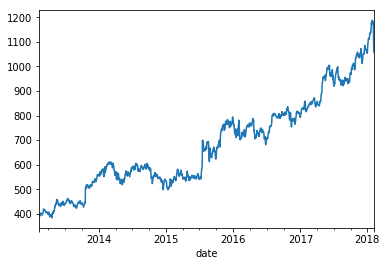

In [0]:
df_ffill = df_raw.iloc[1:]
df_ffill = df_ffill.fillna(method='ffill')
df_ffill['close'].asfreq('B').plot()
plt.show()

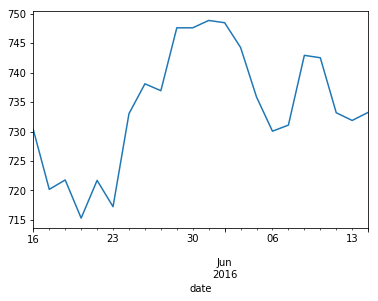

In [0]:
df_ffill.loc['2016-05-14':'2016-06-14']['close'].asfreq('B').plot()

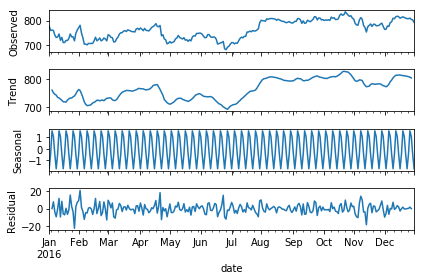

In [0]:
result = seasonal_decompose(df.loc['2016-01-01':'2017-01-01']['close'], model='additive')
result.plot();

# Data Preprocessing

(Option 1) For a single S&P company:

In [18]:
df_with_targets = df_raw.copy()
predict_num_days_ahead = 1
df_with_targets['target_reg'] = df_with_targets['open'].shift(-predict_num_days_ahead)
df_with_targets = df_with_targets.iloc[:-1]
df_with_targets['target_class'] = df_with_targets['target_reg'] > df_with_targets['close']
df = df_with_targets.copy()
df = df.dropna()
df.head()

,open,high,low,close,volume,news,target_reg,target_class
date,,,,,,,,
2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199,Google Changes Its Ad Program to Try to Solve ...,389.5892,False
2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781,,391.2659,False
2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176,,390.4551,False
2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946,Lost in Translation? Try a Google App: Google’...,390.2549,False
2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971,,394.0937,False


(Option 2) For all companies dataset:

In [0]:
df_with_targets = df_raw.copy()
df_with_targets[['target_reg', 'Name2']] = df_with_targets[['open', 'Name']].shift(-1)
df_with_targets = df_with_targets[df_with_targets['Name'] == df_with_targets['Name2']]
df_with_targets['target_class'] = df_with_targets['target_reg'] > df_with_targets['close']
df_with_targets.drop('Name2', inplace=True, axis=1)
df_with_targets = pd.get_dummies(df_with_targets, drop_first=True)
df = df_with_targets.copy()
df = df.dropna()
df.head()

(Option 3) For headlines only

In [0]:
df_with_targets = df_raw.copy()
predict_num_days_ahead = 2
df_with_targets['target_reg'] = df_with_targets['open'].shift(-predict_num_days_ahead)
df_with_targets = df_with_targets.iloc[:-1]
df_with_targets['target_class'] = df_with_targets['target_reg'] > df_with_targets['close']
df = df_with_targets.copy()
df = df.dropna()
df = df[['news', 'target_class']]
df = df[df['news'] != '']
df.head()

,news,target_class
date,,
2013-02-08,Google Changes Its Ad Program to Try to Solve ...,False
2013-02-13,Lost in Translation? Try a Google App: Google’...,True
2013-02-20,Google Will Offer Its Glasses to Select Few: G...,True
2013-02-21,Google Searches for Style: As Google and other...,True
2013-02-25,Q&A: Recommending Web Pages With the Google +1...,True


# Feature Engineering

(Option 1) For a single S&P company

Moving averages:

In [0]:
# ===== Add 20-day moving average =====
df = df_with_targets.copy()
window_size = [50, 20, 5]
max_window_size = max(window_size)

# Init the moving avg
for k in range(len(window_size)):
  moving_avg = 0
  for i in range(max_window_size + 1 - window_size[k], max_window_size + 1):
    moving_avg = moving_avg + df_raw.iloc[i]['close']
  moving_avg = moving_avg / window_size[k]

  df['moving_avg_' + str(window_size[k])] = np.nan
  col_index = df.columns.get_loc("moving_avg_" + str(window_size[k]))
  for j in range(max_window_size, len(df) - 1):
    df.iat[j, col_index] = moving_avg
    moving_avg = moving_avg + (df_raw.iloc[j+1]['close'] - df_raw.iloc[j+1-window_size[k]]['close'])/window_size[k]

df = df.dropna()

# Add amount traded
# df['amount_traded'] = df['open'] * df['volume']

df.head(1)

,open,high,low,close,volume,news,target_reg,target_class,moving_avg_50,moving_avg_20,moving_avg_5
date,,,,,,,,,,,
2013-04-19,384.9646,402.1217,383.5131,400.3349,11593628,,400.9005,True,401.352814,396.856755,392.75678


Text to Sentiment (negative, neutral, positive):

In [55]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

df["sent_compound"] = np.nan
# Passing the individual scores seem to bring down accuracy
# df["sent_neg"] = np.nan
# df["sent_neu"] = np.nan
# df["sent_pos"] = np.nan
for i, sentence in df['news'].items():
    vs = analyzer.polarity_scores(sentence)
    df.loc[i, ["sent_compound"]] = vs['compound']
    # if vs["compound"] != 0:
    #     print("{} {}".format(sentence, str(vs)))
    # if vs["compound"] > 0:
    #     df["sent_compound"] = 1
    # elif vs["compound"] != 0:
    #     df["sent_compound"] = 0
    # elif vs["compound"] < 0:
    #     df["sent_compound"] = -1
    # df.loc[i, ["sent_neg"]] = vs['neg']
    # df.loc[i, ["sent_neu"]] = vs['neu']
    # df.loc[i, ["sent_pos"]] = vs['pos']

df = df.drop(['news'], axis=1)
# pd.reset_option('display.max_colwidth')
df.tail(10)

,open,high,low,close,volume,target_reg,target_class,sent_compound
date,,,,,,,,
2018-01-23,1170.62,1178.51,1167.25,1176.17,1956865,1180.71,True,0.5423
2018-01-24,1184.98,1187.05,1167.40,1171.29,1856429,1187.53,True,0.0000
2018-01-25,1180.71,1185.00,1171.84,1182.14,1499247,1188.00,True,0.0000
2018-01-26,1187.53,1187.56,1168.03,1187.56,2108502,1177.72,False,0.4215
2018-01-29,1188.00,1198.00,1184.06,1186.48,1574708,1183.81,False,0.0000
2018-01-30,1177.72,1187.93,1174.51,1177.37,1866883,1175.99,False,0.0000
2018-01-31,1183.81,1186.32,1172.10,1182.22,1801135,1127.42,False,0.0000
2018-02-01,1175.99,1187.45,1169.36,1181.59,3675709,1100.61,False,0.0000
2018-02-02,1127.42,1131.30,1111.17,1119.20,5892122,1033.98,False,-0.2263


Past data:

In [0]:
# Add past data
past_num_days = 1
for i in range(1, past_num_days+1):
  df['open_prev_' + str(i)] = df['open'].shift(i)
  df['high_prev_' + str(i)] = df['high'].shift(i)
  df['low_prev_' + str(i)] = df['low'].shift(i)
  df['close_prev_' + str(i)] = df['close'].shift(i)
  df['volume_prev_' + str(i)] = df['volume'].shift(i)
df = df.dropna()
df.head(1)

Gradient of moving averages:

In [0]:
# Experiments
past_num_days = 1
# for i in range(1, past_num_days+1):
#   df['volume_prev_' + str(i)] = df['volume'].shift(i)
# df = df.dropna()

# Exponentially Weighted Moving Average
# df['ewma10'] = pd.Series.ewm(df['close'], span=20).mean()

# Gradient
# df['moving_avg_5_shifted'] = df['moving_avg_5'].shift(5)
# df['moving_avg_5_diff'] = df['moving_avg_5'] - df['moving_avg_5_shifted'] 

# df['moving_avg_20_shifted'] = df['moving_avg_20'].shift(20)
# df['moving_avg_20_diff'] = df['moving_avg_20'] - df['moving_avg_20_shifted'] 

# df['moving_avg_50_shifted'] = df['moving_avg_50'].shift(50)
# df['moving_avg_50_diff'] = df['moving_avg_50'] - df['moving_avg_50_shifted'] 

# df['open_to_close_ratio'] = df['open']/df['close']
# df['high_to_low_ratio'] = df['high']/df['low']
# df['mean_high_to_low'] = (df['high'] + df['low']) / 2
# df['close_to_moving_ratio'] = df['close']/df['moving_avg_5']

df = df.dropna()
# df = df.drop(['moving_avg_5_shifted',
#               'moving_avg_20', 'moving_avg_5', 'moving_avg_50'], axis=1)
df.tail(1)


(Option 2) For all company dataset

In [0]:
df = df_with_targets.copy()
df['close'] = (df['close'] - df['open'])/df['open']
df['high'] = (df['high'] - df['open'])/df['open']
df['low'] = (df['low'] - df['open'])/df['open']
df.head()

# Utility Functions (don't care)

In [0]:
def classification_score(y_test, y_pred):
  y_test = pd.DataFrame(y_test, columns=['target_class'])
  y_pred = pd.DataFrame(y_pred, columns=['pred_class'])
  y_test = y_test.reset_index()
  y_test = pd.concat([y_test, y_pred], axis=1)
  score = y_test['target_class'] == y_test['pred_class']
  score = score.astype(int)
  score = score.sum() / score.shape[0]
  print("Test score: ", score)

# KNN Regressor
Using pure Regression and not Time Series. Structured the problem as the regression problem

In [0]:
from sklearn.neighbors import KNeighborsRegressor
y = df['target_reg']
x = df.drop(['target_class', 'target_reg'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle=False)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

regressor = KNeighborsRegressor(n_neighbors=15)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
regressor.score(x_test, y_test)

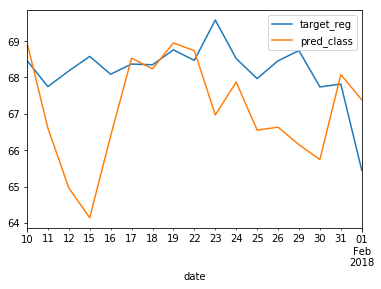

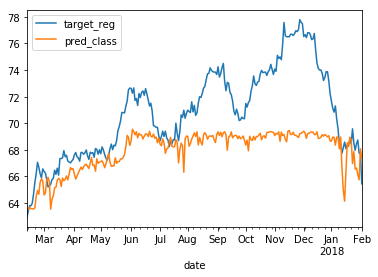

In [0]:
y_test = pd.DataFrame(y_test, columns=['target_reg'])
y_pred = pd.DataFrame(y_pred, columns=['pred_class'])
y_test = y_test.reset_index()
y_test = pd.concat([y_test, y_pred], axis=1)
y_test = y_test.iloc[:-1]
y_test['date'] = pd.to_datetime(y_test['date'])
y_test.set_index('date', inplace=True)
y_test.sort_index(inplace=True)
y_test.loc['2018-01-10':].plot()
y_test.plot()

# KNN Classifier
Classifying whether the opening stock price on the next day increases or decreases. \\
0.64 accuracy, 0.050 std - using K-fold cross validation

In [31]:
from sklearn.neighbors import KNeighborsClassifier
y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
classifier.score(x_test, y_test)

0.5478927203065134

In [0]:
classification_score(y_test, y_pred)

# Random Forest Classifier

0.76 accuracy, 0.052 std  - using K-fold cross validation, better than KNN. Random Forest Classifier's score function is weird.

In [0]:
df = df.drop(['news'], axis=1)

In [0]:
from sklearn.ensemble import RandomForestClassifier

# limit = 100000 # limit samples
# df = df.iloc[:limit]
y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

classifier = RandomForestClassifier(n_estimators=20, criterion='entropy')
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print(classifier.score(x_test, y_test))
cm = confusion_matrix(y_test, y_pred)
print(cm)
# import seaborn as sn
# sn.heatmap(cm, annot=True)
# See Feature Importance
feat_importances = pd.Series(classifier.feature_importances_, index=x.columns)
print(feat_importances)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh')


In [0]:
classification_score(y_test, y_pred)

NameError: ignored

# AdaBoost

0.59 accuracy, 0.048 std - using K-fold cross validation.

In [25]:
from sklearn.ensemble import AdaBoostClassifier
y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

classifier = AdaBoostClassifier()
classifier.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

# XGBoost

0.73 accuracy, 0.036 std - using K-fold cross validation.

In [48]:
from xgboost import XGBClassifier
y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

classifier = XGBClassifier()
classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# K-Fold Cross Validation

In [49]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
# accuracies = cross_val_score(estimator = classifier, X = scaled_x_train, y = y_train, cv = 10)
print("Mean: ", accuracies.mean())
print("Std: ", accuracies.std())

Mean:  0.5841371492585086
Std:  0.032530449958809604


#Combined

In [9]:
# Reading the data
# df_raw = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/AEP_data.csv', index_col="date", parse_dates=True)
df_raw = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/GOOGL_data_with_news_3.csv', index_col="date", parse_dates=True)
df_raw = df_raw.resample('B').pad()
df_raw.index.freq = 'B'
df_raw.drop(['Name'], axis=1, inplace=True)

# df_raw = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/google_facebook_microsoft_news.csv')
# df_raw.drop(['Name', 'Unnamed: 0', 'date'], axis=1, inplace=True)



df_raw['news'] = df_raw['main_news'].replace(np.nan, '', regex=True)
df_raw = df_raw.drop(['main_news', 'tagged_news'], axis=1)

df_with_targets = df_raw.copy()
predict_num_days_ahead = 2
df_with_targets['target_reg'] = df_with_targets['open'].shift(-predict_num_days_ahead)
df_with_targets = df_with_targets.iloc[:-1]
df_with_targets['target_class'] = df_with_targets['target_reg'] > df_with_targets['close']
df = df_with_targets.copy()
df = df.dropna()


# Feature Engineering
# ===== Add moving averages (close) =====
df = df_with_targets.copy()
window_size = [50, 20, 5]
max_window_size = max(window_size)
for k in range(len(window_size)):
  moving_avg = 0
  for i in range(max_window_size + 1 - window_size[k], max_window_size + 1):
    moving_avg = moving_avg + df_raw.iloc[i]['close']
  moving_avg = moving_avg / window_size[k]

  df['moving_avg_' + str(window_size[k])] = np.nan
  col_index = df.columns.get_loc("moving_avg_" + str(window_size[k]))
  for j in range(max_window_size, len(df) - 1):
    df.iat[j, col_index] = moving_avg
    moving_avg = moving_avg + (df_raw.iloc[j+1]['close'] - df_raw.iloc[j+1-window_size[k]]['close'])/window_size[k]
df = df.dropna()

# ===== Add moving averages (volume) =====
# window_size = [5]
# max_window_size = max(window_size)
# for k in range(len(window_size)):
#   moving_avg = 0
#   for i in range(max_window_size + 1 - window_size[k], max_window_size + 1):
#     moving_avg = moving_avg + df_raw.iloc[i]['volume']
#   moving_avg = moving_avg / window_size[k]

#   df['vol_moving_avg_' + str(window_size[k])] = np.nan
#   col_index = df.columns.get_loc("vol_moving_avg_" + str(window_size[k]))
#   for j in range(max_window_size, len(df) - 1):
#     df.iat[j, col_index] = moving_avg
#     moving_avg = moving_avg + (df_raw.iloc[j+1]['volume'] - df_raw.iloc[j+1-window_size[k]]['volume'])/window_size[k]
# df = df.dropna()




# # ===== Text Sentiment =====
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# analyzer = SentimentIntensityAnalyzer()
# df["sent_compound"] = np.nan
# # Passing the individual scores seem to bring down accuracy
# # df["sent_neg"] = np.nan
# # df["sent_neu"] = np.nan
# # df["sent_pos"] = np.nan
# for i, sentence in df['news'].items():
#     vs = analyzer.polarity_scores(sentence)
#     df.loc[i, ["sent_compound"]] = vs['compound']
#     # if vs["compound"] != 0:
#     #     print("{} {}".format(sentence, str(vs)))
#     # if vs["compound"] > 0:
#     #     df["sent_compound"] = 1
#     # elif vs["compound"] != 0:
#     #     df["sent_compound"] = 0
#     # elif vs["compound"] < 0:
#     #     df["sent_compound"] = -1
#     # df.loc[i, ["sent_neg"]] = vs['neg']
#     # df.loc[i, ["sent_neu"]] = vs['neu']
#     # df.loc[i, ["sent_pos"]] = vs['pos']

df = df.drop(['news'], axis=1)




# ===== Add past data ===== 
# past_num_days = 1
# for i in range(1, past_num_days+1):
#   df['open_prev_' + str(i)] = df['open'].shift(i)
#   df['high_prev_' + str(i)] = df['high'].shift(i)
#   df['low_prev_' + str(i)] = df['low'].shift(i)
#   df['close_prev_' + str(i)] = df['close'].shift(i)
#   df['volume_prev_' + str(i)] = df['volume'].shift(i)
# df = df.dropna()




# ===== Gradients ===== 
# past_num_days = 1
# for i in range(1, past_num_days+1):
#   df['volume_prev_' + str(i)] = df['volume'].shift(i)
# df = df.dropna()

# Exponentially Weighted Moving Average
# df['ewma10'] = pd.Series.ewm(df['close'], span=20).mean()

# Gradient
# df['moving_avg_5_shifted'] = df['moving_avg_5'].shift(5)
# df['moving_avg_5_diff'] = df['moving_avg_5'] - df['moving_avg_5_shifted'] 

# df['moving_avg_20_shifted'] = df['moving_avg_20'].shift(20)
# df['moving_avg_20_diff'] = df['moving_avg_20'] - df['moving_avg_20_shifted'] 

# df['moving_avg_50_shifted'] = df['moving_avg_50'].shift(50)
# df['moving_avg_50_diff'] = df['moving_avg_50'] - df['moving_avg_50_shifted'] 

# df['open_to_close_ratio'] = df['open']/df['close']
# df['high_to_low_ratio'] = df['high']/df['low']
# df['mean_high_to_low'] = (df['high'] + df['low']) / 2
# df['close_to_moving_ratio'] = df['close']/df['moving_avg_5']

# df = df.drop(['moving_avg_5_shifted',
#               'moving_avg_20', 'moving_avg_5', 'moving_avg_50'], axis=1)

# df = df[['moving_avg_5', 'moving_avg_20', 'moving_avg_50', 'target_class', 'target_reg']]
df.head(10)


,open,high,low,close,volume,target_reg,target_class,moving_avg_50,moving_avg_20,moving_avg_5
date,,,,,,,,,,
2013-04-19,384.9646,402.1217,383.5131,400.3349,11593628,400.9005,True,401.352814,396.856755,392.75678
2013-04-22,400.7003,402.3810,387.8875,400.4571,5760454,404.4591,True,401.529932,396.618370,394.57700
2013-04-23,400.9005,408.1578,400.5802,404.3539,4579994,408.5331,True,401.802204,396.505255,396.03144
2013-04-24,404.4591,409.4090,404.4040,407.1337,3654448,404.2038,False,402.108450,396.775375,399.12392
2013-04-25,408.5331,408.6432,404.2188,404.9545,3980422,402.0266,False,402.321462,397.148545,403.44682
2013-04-26,404.2038,404.2739,398.6883,401.1107,4970304,409.9095,True,402.406848,397.329525,403.60198
2013-04-29,402.0266,411.7613,401.9015,409.9395,4595912,412.0416,True,402.668810,397.776720,405.49846
2013-04-30,409.9095,414.2338,409.2488,412.6973,4608663,410.4601,False,402.846188,398.065260,407.16714
2013-05-01,412.0416,412.7724,408.5882,410.6252,2906961,418.8985,True,403.126168,398.421315,407.86544


In [0]:
y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
feature_importance = pd.DataFrame(pca.components_, columns=list(x.columns))
print(feature_importance)

# number of components
n_pcs = pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = x.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_test = pd.DataFrame(dic.items())
df_test.head()

       open      high       low  ...  moving_avg_50  moving_avg_20  moving_avg_5
0  0.373177  0.373060  0.373278  ...       0.370813       0.372773      0.373404
1  0.069930  0.076632  0.060035  ...       0.042436       0.056478      0.062626

[2 rows x 8 columns]


,0,1
0,PC0,moving_avg_5
1,PC1,volume


------ KNN ------
------ Random Forest ------
Mean:  0.5893627362736275
Std:  0.06814668690338124
[[57 55]
 [49 90]]
------ AdaBoost ------
Mean:  0.5613492349234923
Std:  0.04718791332593357
[[ 40  72]
 [ 35 104]]
------ XGBoost ------
Mean:  0.5944025402540254
Std:  0.052343006890760185
[[ 44  68]
 [ 32 107]]
------ SVM ------
Mean:  0.5494385438543855
Std:  0.010287668064458515
[[  0 112]
 [  1 138]]


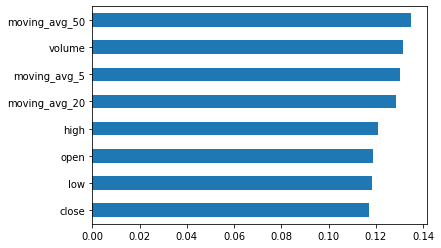

In [11]:
all_model_predictions = pd.DataFrame(columns=['RF_pred', 'Ada_pred', 'XG_pred', 'ensemble_pred', 'target_class', 'error'])

# Models
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("------ KNN ------")
# accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
# print("Mean: ", accuracies.mean())
# print("Std: ", accuracies.std())



from sklearn.ensemble import RandomForestClassifier
# y = df['target_class']
# x = df.drop(['target_class', 'target_reg'], axis=1)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
classifier = RandomForestClassifier(n_estimators=300, criterion='entropy')
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("------ Random Forest ------")
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
print("Mean: ", accuracies.mean())
print("Std: ", accuracies.std())
print(cm)
all_model_predictions['RF_pred'] = y_pred
feat_importances = pd.Series(classifier.feature_importances_, index=x.columns)
# print(feat_importances)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh')



from sklearn.ensemble import AdaBoostClassifier
# y = df['target_class']
# x = df.drop(['target_class', 'target_reg'], axis=1)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
classifier = AdaBoostClassifier(n_estimators=100)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("------ AdaBoost ------")
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
print("Mean: ", accuracies.mean())
print("Std: ", accuracies.std())
print(cm)
all_model_predictions['Ada_pred'] = y_pred


# from sklearn.ensemble import GradientBoostingClassifier
# classifier = GradientBoostingClassifier(n_estimators=100)
# classifier.fit(x_train, y_train)
# y_pred = classifier.predict(x_test)
# cm = confusion_matrix(y_test, y_pred)
# print("------ GradientBoostingClassifier ------")
# accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
# print("Mean: ", accuracies.mean())
# print("Std: ", accuracies.std())
# print(cm)
# all_model_predictions['Ada_pred'] = y_pred


from xgboost import XGBClassifier
# y = df['target_class']
# x = df.drop(['target_class', 'target_reg'], axis=1)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
classifier = XGBClassifier(n_estimators=100)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("------ XGBoost ------")
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
print("Mean: ", accuracies.mean())
print("Std: ", accuracies.std())
print(cm)
all_model_predictions['XG_pred'] = y_pred


from sklearn.svm import SVC
classifier = SVC(kernel='rbf', gamma='auto')
# y_train = y_train.values
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("------ SVM ------")
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
print("Mean: ", accuracies.mean())
print("Std: ", accuracies.std())
print(cm)


# from sklearn.gaussian_process import GaussianProcessClassifier
# classifier = GaussianProcessClassifier()
# # y_train = y_train.values
# classifier.fit(x_train, y_train)
# y_pred = classifier.predict(x_test)
# cm = confusion_matrix(y_test, y_pred)
# print("------ Gaussian Process Classifier ------")
# accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
# print("Mean: ", accuracies.mean())
# print("Std: ", accuracies.std())
# print(cm)

# from sklearn.naive_bayes import GaussianNB
# classifier = GaussianNB()
# classifier.fit(x_train, y_train)
# y_pred = classifier.predict(x_test)
# cm = confusion_matrix(y_test, y_pred)
# print("------ Naive Bayes ------")
# accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
# print("Mean: ", accuracies.mean())
# print("Std: ", accuracies.std())
# print(cm)

# from sklearn.neural_network import MLPClassifier
# classifier = MLPClassifier()
# classifier.fit(x_train, y_train)
# y_pred = classifier.predict(x_test)
# cm = confusion_matrix(y_test, y_pred)
# print("------ MLP ------")
# accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
# print("Mean: ", accuracies.mean())
# print("Std: ", accuracies.std())
# print(cm)


In [12]:
# all_model_predictions['target_class'] = y_test.values
all_model_predictions['Ada_pred'] = all_model_predictions['Ada_pred'] > 0.5
all_model_predictions['RF_pred'] = all_model_predictions['RF_pred'].astype(int)
all_model_predictions['Ada_pred'] = all_model_predictions['Ada_pred'].astype(int)
all_model_predictions['XG_pred'] = all_model_predictions['XG_pred'].astype(int)
all_model_predictions['ensemble_pred'] = all_model_predictions.mode(axis=1)
all_model_predictions['target_class'] = y_test.values
all_model_predictions['target_class'] = all_model_predictions['target_class'].astype(int)
accuracy = 1 - ((all_model_predictions['ensemble_pred'] - all_model_predictions['target_class']).abs()).sum() / all_model_predictions.shape[0]

print(accuracy)
# all_model_predictions.head(100)
all_model_predictions[all_model_predictions['Ada_pred'] < 0.5].head(100)


0.5856573705179282


,RF_pred,Ada_pred,XG_pred,ensemble_pred,target_class,error
0,0,0,0,0,1,NaN
1,0,0,0,0,1,NaN
3,0,0,0,0,1,NaN
8,0,0,0,0,1,NaN
19,1,0,0,0,0,NaN
...,...,...,...,...,...,...
238,1,0,1,1,0,NaN
239,1,0,1,1,0,NaN
240,1,0,1,1,1,NaN
247,1,0,1,1,1,NaN


# Simple Neural Network for Classification

(Option 1) No cross validation

In [0]:
from keras import optimizers
from sklearn.preprocessing import StandardScaler

# y = df['target_class']
# x = df.drop(['target_class', 'target_reg'], axis=1)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

# sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

model = Sequential()
model.add(Dropout(0.2, input_shape=(8,)))
model.add(Dense(5, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(x_train, y_train, epochs=50, batch_size=30)
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

y_pred = model.predict(x_test)
# cm = confusion_matrix(y_test, y_pred)
# all_model_predictions['Ada_pred'] = y_pred


(Option 2) With cross validation (manual)

In [0]:
# With K-fold cross validation
from keras import optimizers
from sklearn.preprocessing import StandardScaler

y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)

def create_model():
  model = Sequential()
  model.add(Dense(5, input_dim=9, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(5, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
  return model

from sklearn.model_selection import KFold
 
n_split=5
accuracies = []
for train_index, test_index in KFold(n_split).split(x):
  sc = StandardScaler()
  x = sc.fit_transform(x)
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  model = create_model()
  model.fit(x_train, y_train,epochs=150)
  accuracies.append(model.evaluate(x_test, y_test)[1])
  
  # print('Model evaluation ', model.evaluate(x_test, y_test))
print(accuracies)

(Option 3) With cross validation (using SciKit learn)

In [60]:
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)
sc = StandardScaler()
x = sc.fit_transform(x)

def create_network():
    model = Sequential()
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(5,)))
    model.add(Dense(5, input_dim=6, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=100, 
                                 batch_size=20, 
                                 verbose=0)

score = cross_val_score(neural_network, x, y, cv=5)
print(score)
sum = 0
for i in range(len(score)):
    sum += score[i]
print(sum/len(score))

[0.55555556 0.51724139 0.54230769 0.55       0.47692308]
0.5284055439255212


(Option 4) Using LSTM

In [333]:
from keras import optimizers
from sklearn.preprocessing import StandardScaler

y = df['target_class']
x = df.drop(['target_class', 'target_reg'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train_reshaped = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test_reshaped = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
# model.add(Dropout(0.2, input_shape=(5,)))
model.add(LSTM(units = 5, return_sequences = True, input_shape=(x_train.shape[1], 1), activation='relu'))
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))
model.add(LSTM(units = 50))
# model.add(Dense(20, activation='relu'))
# model.add(Dense(20, activation='relu'))
# model.add(Dense(20, activation='relu'))
# model.add(Dense(20, activation='relu'))
# model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(x_train_reshaped, y_train, epochs=100, batch_size=10)
_, accuracy = model.evaluate(x_test_reshaped, y_test)
print('Accuracy: %.2f' % (accuracy*100))

# cm = confusion_matrix(y_test, y_pred)
# all_model_predictions['Ada_pred'] = y_pred

# # With K-fold cross validation
# from keras import optimizers
# from sklearn.preprocessing import StandardScaler

# y = df['target_class']
# x = df.drop(['target_class', 'target_reg'], axis=1)

# def create_model():
#   model = Sequential()
#   # model.add(Dropout(0.2, input_shape=(5,)))
#   model.add(LSTM(units = 5, input_shape=(x_train.shape[1], 1), activation='relu'))
#   model.add(Dense(10, activation='relu'))
#   model.add(Dense(10, activation='relu'))
#   model.add(Dense(5, activation='relu'))
#   model.add(Dense(1, activation='sigmoid'))
#   model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
#   return model

# from sklearn.model_selection import KFold
 
# n_split=5
# accuracies = []
# for train_index, test_index in KFold(n_split).split(x):
#   print(train_index)
#   print(test_index)
#   sc = StandardScaler()
#   x_train, x_test = x[train_index], x[test_index]
#   y_train, y_test = y[train_index], y[test_index]
  
#   x_train = sc.fit_transform(x_train)
#   x_test = sc.transform(x_test)
#   x_train_reshaped = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#   x_test_reshaped = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#   model = create_model()
#   model.fit(x_train_reshaped, y_train, epochs=1)
#   accuracies.append(model.evaluate(x_test, y_test)[1])
  
#   # print('Model evaluation ', model.evaluate(x_test, y_test))
# print(accuracies)

Epoch 1/100
1001/1001 [==============================] - 15s 15ms/step - loss: 0.6896 - acc: 0.5504
Epoch 2/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.6886 - acc: 0.5554
Epoch 3/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.6876 - acc: 0.5554
Epoch 4/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.6875 - acc: 0.5554
Epoch 5/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.6872 - acc: 0.5554
Epoch 6/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.6870 - acc: 0.5554
Epoch 7/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.6867 - acc: 0.5524
Epoch 8/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.6871 - acc: 0.5554
Epoch 9/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.6867 - acc: 0.5554
Epoch 10/100
1001/1001 [==============================] - 2s 2ms/step - loss: 0.6868 - acc: 0.5554
Epoch 11/100
1001

ValueError: ignored

In [191]:
df.head()

,open,high,low,close,volume,target_reg,target_class,moving_avg_50,moving_avg_20,moving_avg_5
date,,,,,,,,,,
2013-04-19,384.9646,402.1217,383.5131,400.3349,11593628,400.9005,True,401.352814,396.856755,392.75678
2013-04-22,400.7003,402.3810,387.8875,400.4571,5760454,404.4591,True,401.529932,396.618370,394.57700
2013-04-23,400.9005,408.1578,400.5802,404.3539,4579994,408.5331,True,401.802204,396.505255,396.03144
2013-04-24,404.4591,409.4090,404.4040,407.1337,3654448,404.2038,False,402.108450,396.775375,399.12392
2013-04-25,408.5331,408.6432,404.2188,404.9545,3980422,402.0266,False,402.321462,397.148545,403.44682


# Time Series Exploration

Using Regression instead of Classification

In [378]:
# Test Train split
num_observations = 20
train, test = df[0:-num_observations], df[-num_observations:]
train = train.drop(["news"], axis=1)
test = test.drop(["news"], axis=1)
train.tail(10)

,open,high,low,close,volume,target_reg,target_class
date,,,,,,,
2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,1062.25,True
2017-12-28,1062.25,1064.84,1053.38,1055.95,994249,1055.49,False
2017-12-29,1055.49,1058.05,1052.70,1053.40,1180340,1055.49,True
2018-01-01,1055.49,1058.05,1052.70,1053.40,1180340,1053.02,False
2018-01-02,1053.02,1075.98,1053.02,1073.21,1588268,1073.93,True
2018-01-03,1073.93,1096.10,1073.43,1091.52,1565945,1097.09,True
2018-01-04,1097.09,1104.08,1094.26,1095.76,1302569,1103.45,True
2018-01-05,1103.45,1113.58,1101.80,1110.29,1512526,1111.00,True
2018-01-08,1111.00,1119.16,1110.00,1114.21,1232221,1118.44,True


In [0]:
# Test if dataset is stationary
def adf_test(series, title=''):
  print(f'Augmented Dickey-Fuller Test: {title}')
  result = adfuller(series.dropna(), autolag='AIC')
  labels = ['ADF Test Statistic', 'p-value', '# lags used', '# observations']
  out = pd.Series(result[0:4], index=labels)
  return out
adf_test(df['target_reg'].diff())

Augmented Dickey-Fuller Test: 


ADF Test Statistic     -35.42501
p-value                  0.00000
# lags used              0.00000
# observations        1300.00000
dtype: float64

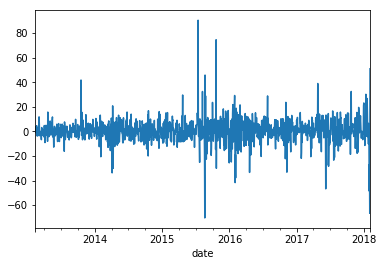

In [0]:
df['target_reg'].diff().plot()

# AUTO ARIMA
Only uses training data.

In [340]:
# Training Models (ARIMA?)
model = auto_arima(train['target_reg'], start_p=0, start_q=0,max_p=3, max_q=3, m=52, seasonal=True, d=1, trace=True, error_action='ignore',suppress_warnings=True)
model.fit(train['target_reg'])
ARIMA_forecast = model.predict(n_periods=num_observations)
ARIMA_forecast = pd.DataFrame(ARIMA_forecast,index = test.index,columns=['target_reg'])

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 52); AIC=9305.236, BIC=9325.858, Fit time=31.777 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 52); AIC=9309.246, BIC=9319.556, Fit time=0.062 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 52); AIC=9306.100, BIC=9326.722, Fit time=19.789 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 52); AIC=9305.617, BIC=9326.238, Fit time=11.972 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 52); AIC=9303.622, BIC=9319.088, Fit time=11.572 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 2, 52); AIC=9304.752, BIC=9325.374, Fit time=70.860 seconds


KeyboardInterrupt: ignored

NameError: ignored

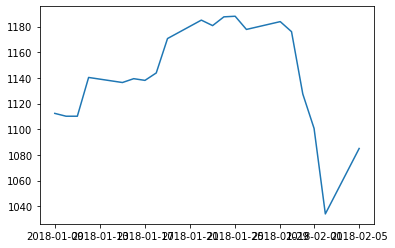

In [341]:
# plt.plot(train['target_reg'])
plt.plot(test['target_reg'])
plt.plot(ARIMA_forecast['target_reg'])

# ARIMA
Rebuild model and append test observation to training data before repredicting the next test data point.

In [0]:
history = [x for x in train['target_reg']]
predictions = list()
for t in range(len(test)):
  model = ARIMA(history, order=(1, 1, 0))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test['target_reg'].iloc[t]
  history.append(obs)

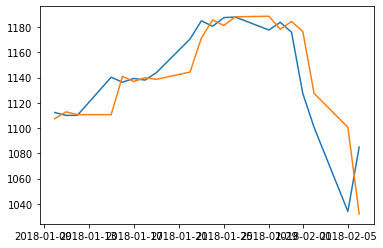

In [362]:
# plt.plot(train.loc['2017-07-01':]['target_reg'])
plt.plot(test['target_reg'])
plt.plot(test.index, predictions)

# SARIMAX
Only uses training data + exog variables from test data ('open', 'high', 'low', 'close', 'volume')

In [379]:
# exog = ['open', 'high', 'low', 'close', 'volume']
# model = SARIMAX(train['target_reg'], order=(1, 1, 1))
# results = model.fit()
# start=len(train)
# end=len(train) + len(test) - 1
# SARIMAX_forecast = results.predict(start=start, end=end, dynamic=False, typ='levels').rename("pred_reg")
# train.tail()
model = SARIMAX(train['target_reg'], exog=train[['open', 'high', 'low', 'close', 'volume']], order=(0, 1, 0))
results = model.fit()
start=len(train)
end=len(train) + len(test) - 1
SARIMAX_forecast = results.predict(start=start, end=end, dynamic=False, typ='levels', exog=test[['open', 'high', 'low', 'close', 'volume']]).rename("pred_reg")
train.tail()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,open,high,low,close,volume,target_reg,target_class
date,,,,,,,
2018-01-03,1073.93,1096.10,1073.43,1091.52,1565945,1097.09,True
2018-01-04,1097.09,1104.08,1094.26,1095.76,1302569,1103.45,True
2018-01-05,1103.45,1113.58,1101.80,1110.29,1512526,1111.00,True
2018-01-08,1111.00,1119.16,1110.00,1114.21,1232221,1118.44,True
2018-01-09,1118.44,1118.44,1108.20,1112.79,1340381,1107.00,False


Test score:  0.35


,open,high,low,close,volume,target_reg,target_class,pred_reg,pred_class
date,,,,,,,,,
2018-01-10,1107.00,1112.78,1103.98,1110.14,1036655,1112.31,True,1108.808227,False
2018-01-11,1112.31,1114.85,1106.48,1112.05,1121216,1110.10,False,1108.469660,False
2018-01-12,1110.10,1131.30,1108.01,1130.65,1929306,1110.10,False,1121.504154,False
2018-01-15,1110.10,1131.30,1108.01,1130.65,1929306,1140.31,True,1121.504154,False
2018-01-16,1140.31,1148.88,1126.66,1130.70,1823100,1136.36,True,1113.759369,False
2018-01-17,1136.36,1139.32,1123.49,1139.10,1391510,1139.35,True,1119.581461,False
2018-01-18,1139.35,1140.59,1124.46,1135.97,1374873,1138.03,True,1116.709774,False
2018-01-19,1138.03,1143.78,1132.50,1143.50,1527554,1143.82,True,1123.480199,False
2018-01-22,1143.82,1166.88,1141.82,1164.16,1477520,1170.62,True,1136.134369,False


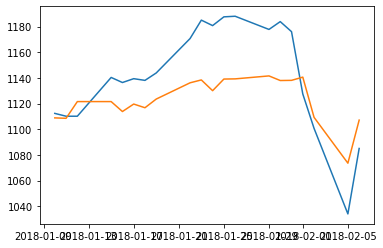

In [380]:
# plt.plot(train.loc['2017-09-01':]['target_reg'])
plt.plot(test['target_reg'])
plt.plot(SARIMAX_forecast)
# SARIMAX_forecast
test_combined = pd.concat([test, SARIMAX_forecast], axis=1)
test_combined['pred_class'] = test_combined['pred_reg'] > test_combined['close']
score = test_combined['target_class'] == test_combined['pred_class']
score = score.astype(int)
score = score.sum() / score.shape[0]
print("Test score: ", score)
test_combined.head(20)

In [0]:
# Evaluate Model
RMSE = rmse(test['target_reg'], forecast['target_reg'])
MSE = mse(test['target_reg'], forecast['target_reg'])
MAE = meanabs(test['target_reg'], forecast['target_reg'])
print(f'Model RMSE: {RMSE:.3f}')
print(f'Model MSE: {MSE:.3f}')
print(f'Model MAE: {MAE:.3f}')

# Keras

Using only the past closing data

In [0]:
train_2 = train['target_reg'].to_frame()
test_2 = test['target_reg'].to_frame()
scaler = MinMaxScaler()
scaler.fit(train_2)
scaled_train = scaler.transform(train_2)
scaled_test = scaler.transform(test_2)
n_input = num_observations
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [0]:
X, y = generator[0]
print(f'Input: \n{X.flatten()}')
print(f'Predict: \n{y}')

Input: 
[0.06922646 0.07371076 0.07763453 0.07455157 0.07679372 0.07679372
 0.08688341 0.09893498 0.0933296  0.09697309 0.11631166 0.11294843
 0.11939462 0.12668161 0.12668161 0.12668161 0.15246637 0.15639013
 0.15526906 0.15386771]
Predict: 
[[0.14798206]]


In [0]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(n_input, n_features)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=1)

Epoch 1/1
1263/1263 [==============================] - 36s 28ms/step - loss: 0.0040


In [0]:
scaled_test[0]

array([0.77045964])

In [0]:
scaled_train[-num_observations:]
first_eval_batch = scaled_train[-num_observations:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)

test_predictions = []
first_eval_batch = scaled_train[-num_observations:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
np.append(current_batch[:, 1:, :], [[[99]]], axis=1)

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[scaled_test[i]]], axis=1)
  
true_predictions = scaler.inverse_transform(test_predictions)
test['predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,open,high,low,close,volume,target_reg,target_class,predictions
date,,,,,,,,
2018-01-10,70.31,70.3600,69.4000,69.50,3978401,69.59,True,71.028979
2018-01-11,69.59,69.8200,68.3800,68.73,2794211,68.47,False,70.686283
2018-01-12,68.47,68.5000,67.2300,67.46,6646960,68.47,True,70.265315
2018-01-15,68.47,68.5000,67.2300,67.46,6646960,67.75,True,69.844608
2018-01-16,67.75,67.9334,67.1111,67.50,3999858,68.18,True,69.404944


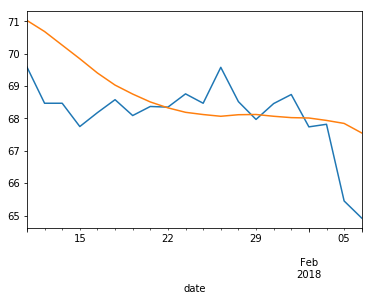

In [0]:
# train.loc['2018-01-01':]['target_reg'].plot()
test['target_reg'].plot()
test['predictions'].plot()
test.head()

# Keras 2

Testing to use all 5 features ('open', 'high', 'low', 'close', 'volume') as input to the Neural Network

In [0]:
df

In [0]:
# Test Train split
num_observations = 20 # length of test data
list_of_features = ['open', 'close', 'volume', 'moving_avg_5_diff', 'moving_avg_20_diff', 'open_to_close_ratio', 'high_to_low_ratio', 'mean_high_to_low', 'close_to_moving_ratio']
df_2 = df[list_of_features]
train, test = df_2[0:-num_observations], df_2[-num_observations:]
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
n_input = 2 # how many days to look back
n_features = 9 # number of features
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1) # look back up to 20 observations ago

In [0]:
X, y = generator[0]
print(f'Input: \n{X.flatten()}')
print(f'Predict: \n{y}')

Input: 
[0.04427002 0.05345912 0.22896355 0.48041958 0.32128072 0.37875775
 0.21126389 0.04986544 0.73597728 0.05086342 0.03805031 0.19563273
 0.56993007 0.33576973 0.62064688 0.23489411 0.04448314 0.51774792]
Predict: 
[[0.033281   0.0418239  0.19098889 0.63321678 0.34954722 0.38489386
  0.09239751 0.03815102 0.5142204 ]]


In [0]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(n_input, n_features)))
model.add(LSTM(50))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=1)

Epoch 1/1
1179/1179 [==============================] - 11s 9ms/step - loss: 0.0147


In [0]:
batch = scaled_train[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

# current_batch = np.append(current_batch[:, 1:, :], [[[99, 99, 99, 99, 99]]], axis=1)
test_predictions = list()
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[scaled_test[i]]], axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
true_predictions = pd.DataFrame(true_predictions, columns=list_of_features)
test['pred_reg'] = np.nan
col_index = test.columns.get_loc("pred_reg")
for i in range(len(test)):
  test.iat[i, col_index] = true_predictions.iloc[i]['open']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


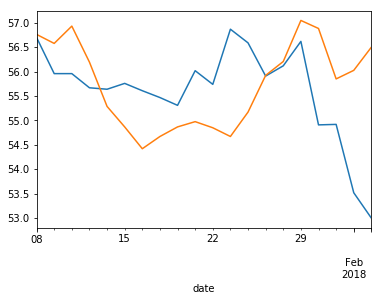

In [0]:
# train.loc['2018-01-14':]['close'].plot()
df[-num_observations:]['target_reg'].plot(label="target_reg")
test['pred_reg'].plot(label="pred_reg")

In [0]:
# Invert differencing
# df_forecast['open_forecast'] = (df['open'].iloc[-num_observations-1]-df['open'].iloc[-num_observations-2]) + df_forecast['open'].cumsum()
# df_forecast['close_forecast'] = (df['close'].iloc[-num_observations-1]-df['close'].iloc[-num_observations-2]) + df_forecast['close'].cumsum()
# pd.concat([df.iloc[-num_observations:], df_forecast[['open_forecast', 'close_forecast']]], axis=1)

# Keras 3

(Option 1) Binary classification

In [113]:
from sklearn.preprocessing import MinMaxScaler
look_back = 5
num_observations = 500

df_keras = df.copy()
# df_keras = df.drop(["news", "target_class"], axis=1)
df_keras['target_class'] = df_keras['target_class'].astype(int)

train, test = df_keras[0:-num_observations], df_keras[-num_observations:]
train.tail()

,open,high,low,close,volume,news,target_reg,target_class
date,,,,,,,,
2016-03-01,721.30,742.330,718.64,742.17,3005553,Autonomous Google Car Hits Public Bus During T...,739.480,0
2016-03-02,742.87,743.121,733.25,739.48,1814643,,734.800,0
2016-03-03,739.48,741.000,729.63,731.59,2026700,,725.150,0
2016-03-04,734.80,735.000,725.62,730.22,2425750,,708.390,0
2016-03-07,725.15,727.210,705.14,712.80,3088278,,715.165,1


In [0]:
sc = MinMaxScaler(feature_range = (0, 1))
x_scaled = sc.fit_transform(train[['open', 'close', 'volume']].values)
y_scaled = train['target_class'].values
x_train = []
y_train = []

# Option 1
x_train, y_train = np.array(x_scaled), np.array(y_scaled)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train

# Option 2
# for i in range(look_back, len(x_scaled)):
#     # Only taking opening price, looking back look_back days
#     x_train.append(x_scaled[i-look_back:i, 0])
#     y_train.append(y_scaled[i-1])
# x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train

In [135]:
regressor = Sequential()
regressor.add(LSTM(units = 50, input_shape = (x_train.shape[1], 1), activation='relu'))
# regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1), activation='relu'))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50, return_sequences = True, activation='relu'))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50, return_sequences = True, activation='relu'))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50, activation='relu'))
# regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1, activation='sigmoid'))
regressor.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
regressor.fit(x_train, y_train, epochs = 10, batch_size = 128)


Epoch 1/10
802/802 [==============================] - 4s 5ms/step - loss: 0.6929 - acc: 0.5299
Epoch 2/10
802/802 [==============================] - 0s 53us/step - loss: 0.6923 - acc: 0.5299
Epoch 3/10
802/802 [==============================] - 0s 56us/step - loss: 0.6921 - acc: 0.5299
Epoch 4/10
802/802 [==============================] - 0s 60us/step - loss: 0.6918 - acc: 0.5299
Epoch 5/10
802/802 [==============================] - 0s 57us/step - loss: 0.6917 - acc: 0.5299
Epoch 6/10
802/802 [==============================] - 0s 54us/step - loss: 0.6916 - acc: 0.5299
Epoch 7/10
802/802 [==============================] - 0s 58us/step - loss: 0.6916 - acc: 0.5299
Epoch 8/10
802/802 [==============================] - 0s 57us/step - loss: 0.6915 - acc: 0.5299
Epoch 9/10
802/802 [==============================] - 0s 56us/step - loss: 0.6915 - acc: 0.5299
Epoch 10/10
802/802 [==============================] - 0s 57us/step - loss: 0.6915 - acc: 0.5299


In [0]:
dataset_total = pd.concat((train[['open', 'close', 'volume']], test[['open', 'close', 'volume']]), axis = 0)
# inputs = dataset_total[len(dataset_total) - len(test) - look_back:].values
inputs = dataset_total[len(dataset_total) - len(test):].values
print(inputs)
# inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
x_test = []
for i in range(look_back, len(inputs)):
    # x_test.append(inputs[i-look_back:i, 0])
    x_test.append(inputs[i, 0])
x_test = np.array(x_test)
print(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price = regressor.predict(x_test)

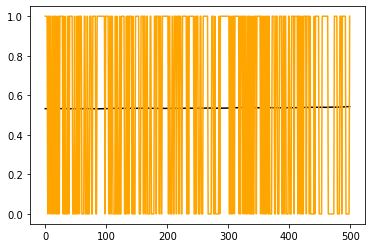

In [137]:
new = pd.DataFrame(predicted_stock_price)
test = test.reset_index()
new['test'] = test['target_class']
new.head()
plt.plot(new[0], color = 'black', label = 'Prediction')
plt.plot(new['test'], color = 'orange', label = 'Actual')

(Option 2) LSTM Regression

In [0]:
from sklearn.preprocessing import MinMaxScaler
look_back = 5
num_observations = 500

df_keras = df.copy()
# df_keras = df.drop(["news", "target_class"], axis=1)
df_keras['target_class'] = df_keras['target_class'].astype(int)

train, test = df_keras[0:-num_observations], df_keras[-num_observations:]
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train['open'].values.reshape(-1, 1))
x_train = []
y_train = []
for i in range(look_back, len(train_scaled)):
    # Only taking opening price, looking back look_back days
    x_train.append(train_scaled[i-look_back:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(x_train, y_train, epochs = 10, batch_size = 128)

dataset_total = pd.concat((train['open'], test['open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
x_test = []
for i in range(look_back, len(inputs)):
    x_test.append(inputs[i-look_back:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price = regressor.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

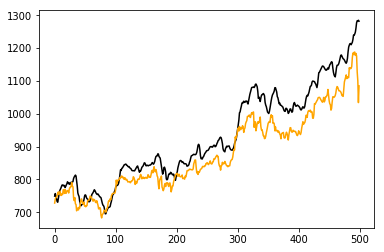

In [0]:

new = pd.DataFrame(predicted_stock_price)
test = test.reset_index()
new['test'] = test['target_reg']
new.head()
plt.plot(new[0], color = 'black', label = 'Prediction')
plt.plot(new['test'], color = 'orange', label = 'Actual')

# Things to try:
- Time Series to predict only 1 day ahead - find a way to do cross validation for this. Test the accuracy against normal Classifiers.
- Feature Engineering:
-> Adding slope (gradient) of trendline from ARIMA models as a feature, then feed it into a Classification model. 
-> Adding moving average
- Dropout regularization for Keras
- Try out normal Neural Networks for Classification (not Time Series)